## 1. Import Libraries and Load Data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import kagglehub
import os

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Prepare the Data

In [2]:
# Download and load the dataset
path = kagglehub.dataset_download("minasameh55/king-country-houses-aa")
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
data_path = os.path.join(path, csv_file)
houses = pd.read_csv(data_path)

print(f"Original dataset shape: {houses.shape}")
print(f"\nColumns: {list(houses.columns)}")
houses.head()

100%|██████████| 780k/780k [00:00<00:00, 68.6MB/s]

Extracting files...
Original dataset shape: (21613, 21)

Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Original dataset shape: (21613, 21)

Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## 3. Data Cleaning and Feature Engineering

In [3]:
# Check for missing values
print("Missing values:")
print(houses.isnull().sum())
print(f"\nDuplicate rows: {houses.duplicated().sum()}")

Missing values:
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Duplicate rows: 0


In [4]:
# Drop unnecessary columns (id, date)
houses = houses.drop(columns=['id', 'date'], errors='ignore')

# Handle yr_renovated - create binary indicator and categorize renovation periods
def categorize_renovation_year_numeric(year):
    if year == 0:
        return 0  # Not Renovated
    elif year < 1980:
        return 1  # Before 1980
    elif year < 1990:
        return 2  # 1980-1989
    elif year < 2000:
        return 3  # 1990-1999
    elif year < 2010:
        return 4  # 2000-2009
    else:
        return 5  # 2010+

houses['was_renovated'] = (houses['yr_renovated'] > 0).astype(int)
houses['renovation_period'] = houses['yr_renovated'].apply(categorize_renovation_year_numeric)

print(f"\nRenovation status distribution:\n{houses['was_renovated'].value_counts()}")
print(f"\nRenovation period distribution:\n{houses['renovation_period'].value_counts().sort_index()}")


Renovation status distribution:
was_renovated
0    20699
1      914
Name: count, dtype: int64

Renovation period distribution:
renovation_period
0    20699
1      122
2      152
3      182
4      272
5      186
Name: count, dtype: int64


In [5]:
# Create additional features
houses["living_to_lot_ratio"] = np.where(
    houses["sqft_lot"] > 0,
    houses["sqft_living"] / houses["sqft_lot"],
    0
)

houses["bath_per_bed"] = np.where(
    houses["bedrooms"] > 0,
    houses["bathrooms"] / houses["bedrooms"],
    houses["bathrooms"]  # If no bedrooms, just use bathroom count
)

houses["living15_diff"] = houses["sqft_living"] - houses["sqft_living15"]

# House age
houses["house_age"] = 2015 - houses["yr_built"]  # Dataset is from 2015

# Total sqft
houses["total_sqft"] = houses["sqft_living"] + houses["sqft_lot"]

print("\nNew features created:")
print("- living_to_lot_ratio")
print("- bath_per_bed")
print("- living15_diff")
print("- house_age")
print("- total_sqft")

print(f"\nFinal dataset shape: {houses.shape}")
houses.head()


New features created:
- living_to_lot_ratio
- bath_per_bed
- living15_diff
- house_age
- total_sqft

Final dataset shape: (21613, 26)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,was_renovated,renovation_period,living_to_lot_ratio,bath_per_bed,living15_diff,house_age,total_sqft
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,-122.257,1340,5650,0,0,0.208850,0.333333,-160,60,6830
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,-122.319,1690,7639,1,3,0.354874,0.750000,880,64,9812
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,-122.233,2720,8062,0,0,0.077000,0.500000,-1950,82,10770
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,-122.393,1360,5000,0,0,0.392000,0.750000,600,50,6960
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,-122.045,1800,7503,0,0,0.207921,0.666667,-120,28,9760


## 4. Prepare Training and Testing Sets

In [6]:
# Separate features and target
X = houses.drop(columns=['price'])
y = houses['price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (17290, 25)
Testing set size: (4323, 25)


## 5. Train XGBoost Model (Baseline)

In [7]:
# Create and train baseline XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Evaluate
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²: {test_r2:.4f}")
print(f"Training RMSE: ${train_rmse:,.2f}")
print(f"Testing RMSE: ${test_rmse:,.2f}")
print(f"Testing MAE: ${test_mae:,.2f}")

Training R²: 0.9396
Testing R²: 0.8673
Training RMSE: $88,854.29
Testing RMSE: $141,654.69
Testing MAE: $72,768.66


## 6. Feature Importance Analysis

/tmp/ipython-input-1643688148.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


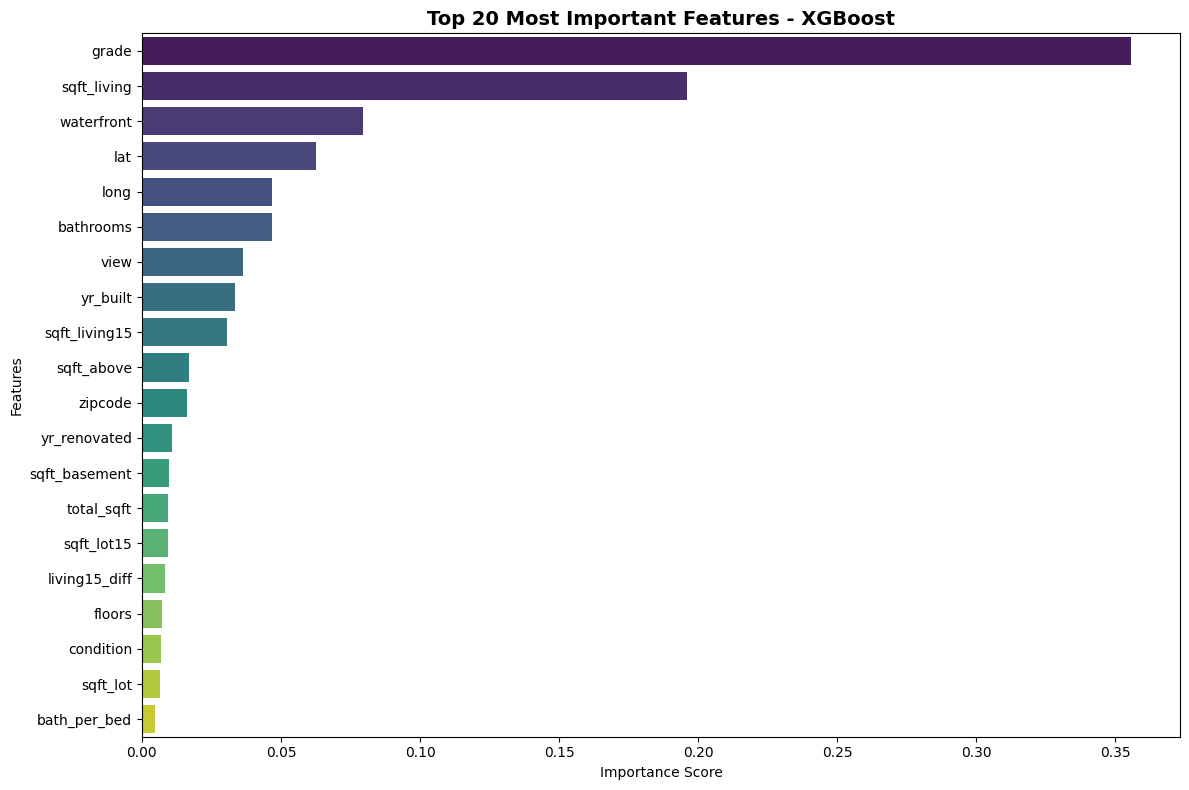


Top 10 Most Important Features:
      feature  importance
        grade    0.355438
  sqft_living    0.195979
   waterfront    0.079513
          lat    0.062492
         long    0.046931
    bathrooms    0.046731
         view    0.036525
     yr_built    0.033505
sqft_living15    0.030476
   sqft_above    0.016777


In [8]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 20 Most Important Features - XGBoost', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 7. Hyperparameter Tuning with GridSearchCV

In [9]:
# Define parameter grid
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [2, 5, 7, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_tuned = xgb.XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_tuned,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 128 candidates, totalling 384 fits


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Best cross-validation R² score: 0.8990


## 8. Evaluate Tuned Model

In [10]:
# Get best model
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred_train_tuned = best_xgb_model.predict(X_train)
y_pred_test_tuned = best_xgb_model.predict(X_test)

# Evaluate tuned model
train_r2_tuned = r2_score(y_train, y_pred_train_tuned)
test_r2_tuned = r2_score(y_test, y_pred_test_tuned)
train_rmse_tuned = np.sqrt(mean_squared_error(y_train, y_pred_train_tuned))
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_test_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_pred_test_tuned)

print(f"Training R²: {train_r2_tuned:.4f}")
print(f"Testing R²: {test_r2_tuned:.4f}")
print(f"Training RMSE: ${train_rmse_tuned:,.2f}")
print(f"Testing RMSE: ${test_rmse_tuned:,.2f}")
print(f"Testing MAE: ${test_mae_tuned:,.2f}")

print(f"R² improvement: {(test_r2_tuned - test_r2):.4f}")
print(f"RMSE reduction: ${(test_rmse - test_rmse_tuned):,.2f}")
print(f"RMSE reduction %: {((test_rmse - test_rmse_tuned) / test_rmse * 100):.2f}%")

Training R²: 0.9628
Testing R²: 0.8608
Training RMSE: $69,686.02
Testing RMSE: $145,068.77
Testing MAE: $69,168.57
R² improvement: -0.0065
RMSE reduction: $-3,414.08
RMSE reduction %: -2.41%


## 9. Prediction Visualization

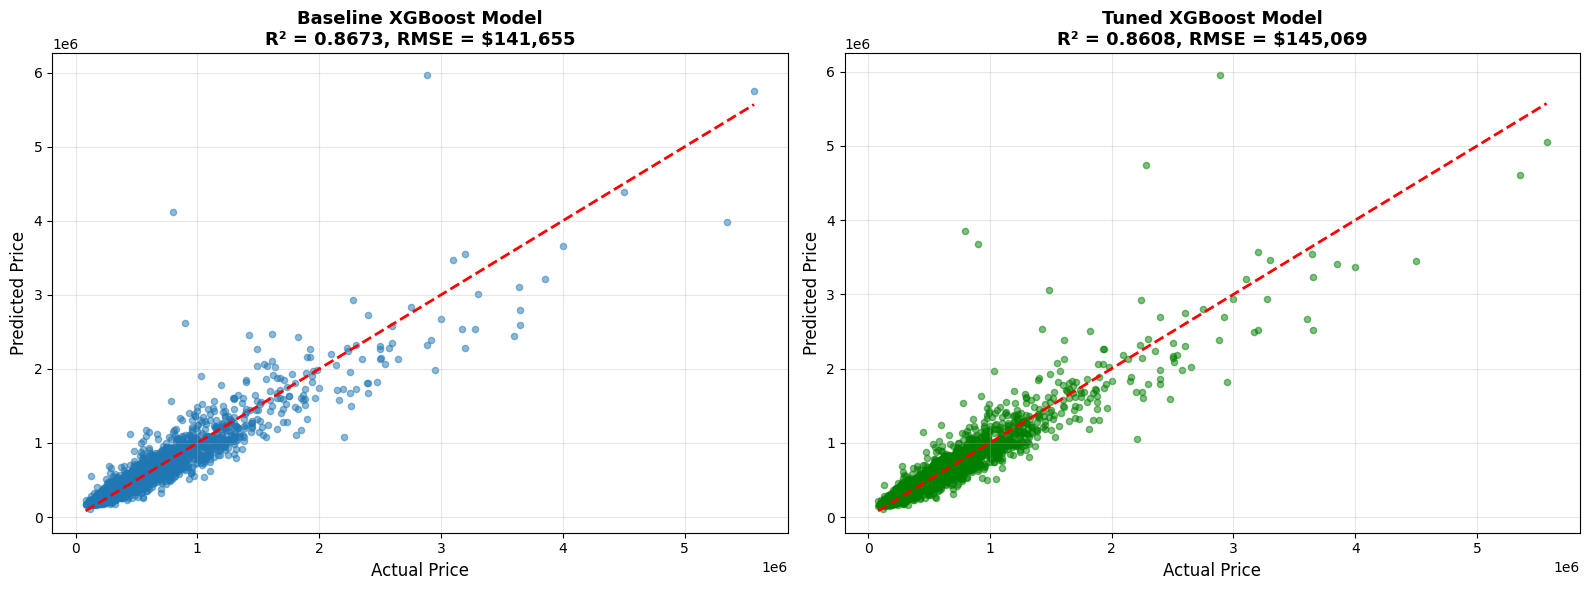

In [11]:
# Actual vs Predicted scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for baseline model
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price', fontsize=12)
axes[0].set_ylabel('Predicted Price', fontsize=12)
axes[0].set_title(f'Baseline XGBoost Model\nR² = {test_r2:.4f}, RMSE = ${test_rmse:,.0f}', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot for tuned model
axes[1].scatter(y_test, y_pred_test_tuned, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price', fontsize=12)
axes[1].set_ylabel('Predicted Price', fontsize=12)
axes[1].set_title(f'Tuned XGBoost Model\nR² = {test_r2_tuned:.4f}, RMSE = ${test_rmse_tuned:,.0f}', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

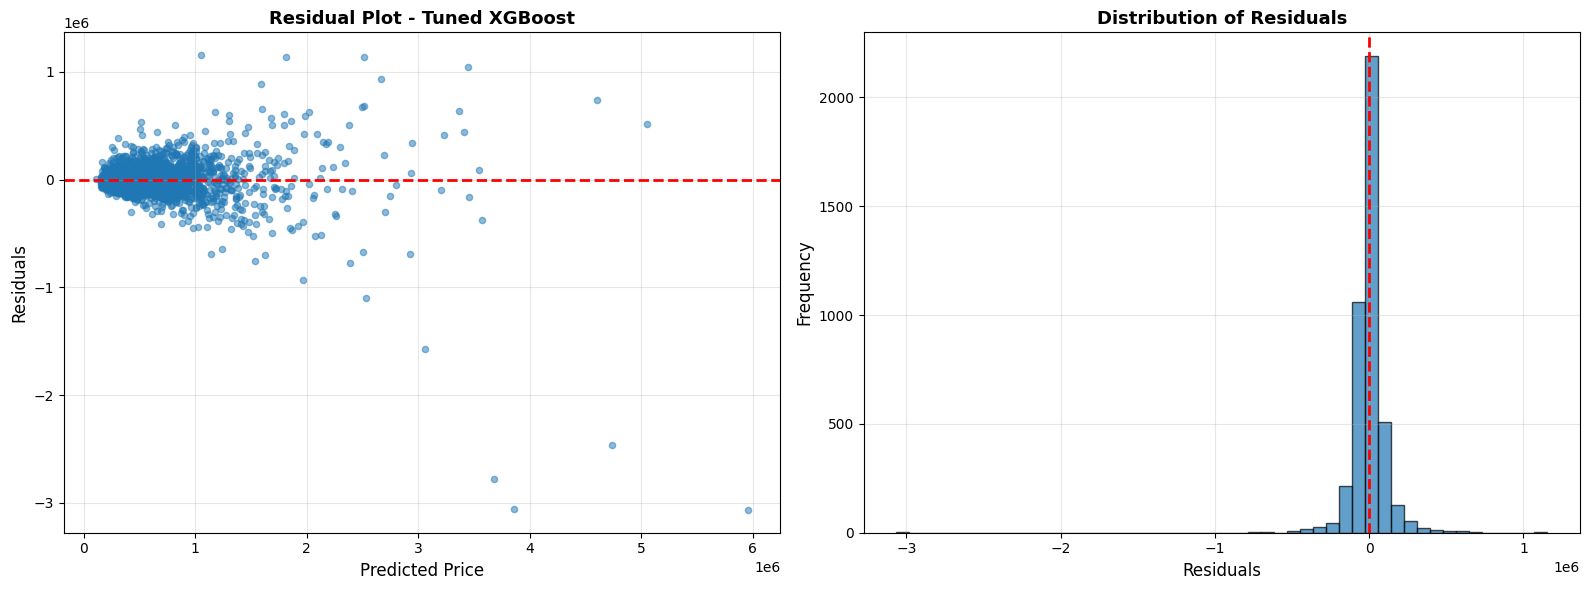

Mean residual: $-1,331.27
Std of residuals: $145,079.44


In [12]:
# Residual plot for tuned model
residuals = y_test - y_pred_test_tuned

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Residuals scatter plot
axes[0].scatter(y_pred_test_tuned, residuals, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residual Plot - Tuned XGBoost', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean residual: ${residuals.mean():,.2f}")
print(f"Std of residuals: ${residuals.std():,.2f}")

## 10. Model Comparison Summary


MODEL PERFORMANCE COMPARISON
           Model  R² Score          RMSE          MAE
XGBoost Baseline  0.867268 141654.690979 72768.656539
   XGBoost Tuned  0.860792 145068.766844 69168.572794


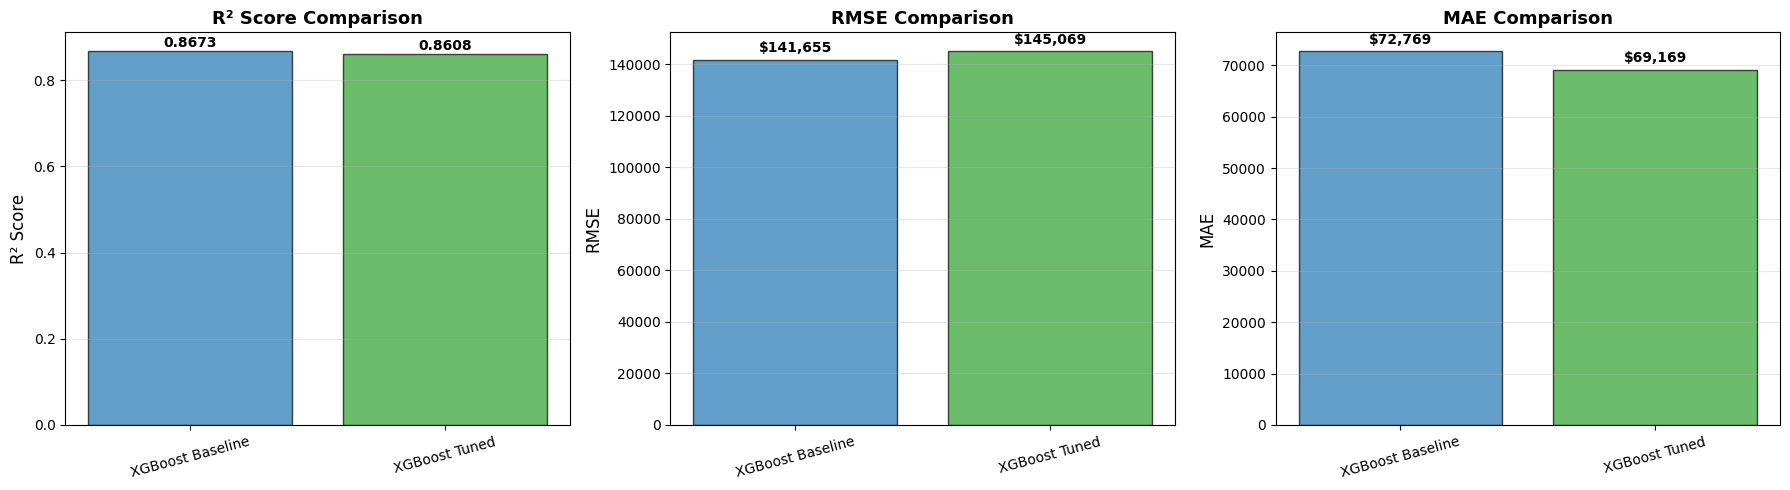

In [13]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['XGBoost Baseline', 'XGBoost Tuned'],
    'R² Score': [test_r2, test_r2_tuned],
    'RMSE': [test_rmse, test_rmse_tuned],
    'MAE': [test_mae, test_mae_tuned]
})

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['R² Score', 'RMSE', 'MAE']
for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison['Model'], comparison[metric], color=['#1f77b4', '#2ca02c'], alpha=0.7, edgecolor='black')
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=15)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(comparison[metric]):
        if metric == 'R² Score':
            axes[idx].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
        else:
            axes[idx].text(i, v + max(comparison[metric])*0.02, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Cross-Validation Analysis

Performing 5-fold cross-validation...
CV R² Scores: [0.8953768  0.89969797 0.91015138 0.90990808 0.89197184]
Mean CV R²: 0.9014
Std CV R²: 0.0074
Min CV R²: 0.8920
Max CV R²: 0.9102
CV R² Scores: [0.8953768  0.89969797 0.91015138 0.90990808 0.89197184]
Mean CV R²: 0.9014
Std CV R²: 0.0074
Min CV R²: 0.8920
Max CV R²: 0.9102


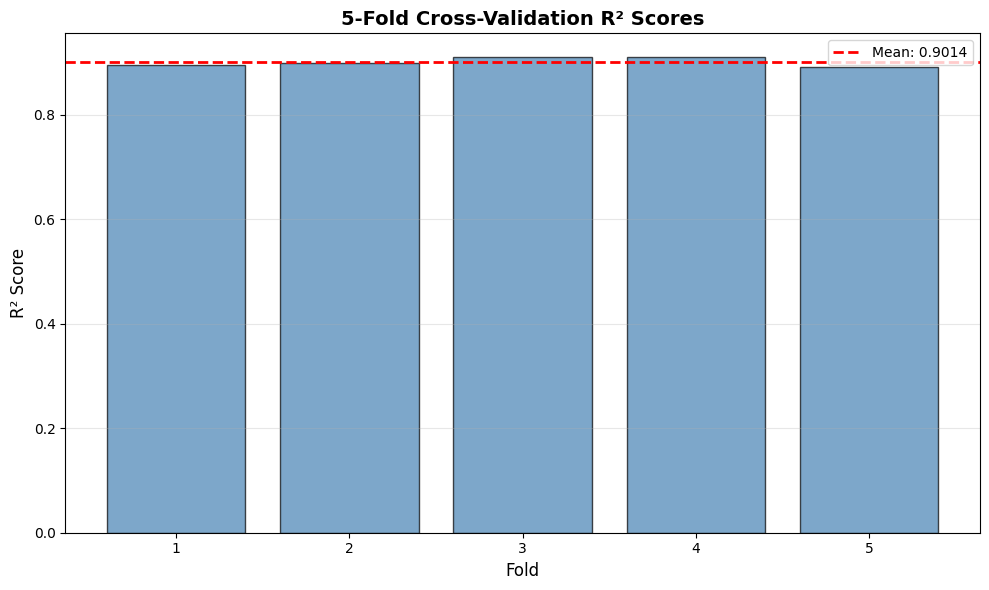

In [14]:
# Perform 5-fold cross-validation on the tuned model
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Std CV R²: {cv_scores.std():.4f}")
print(f"Min CV R²: {cv_scores.min():.4f}")
print(f"Max CV R²: {cv_scores.max():.4f}")
print("="*50)

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='steelblue', alpha=0.7, edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('5-Fold Cross-Validation R² Scores', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 12. Final Summary and Insights

### Key Findings:

1. **Model Performance**: The tuned XGBoost model achieves strong predictive performance on the King County housing dataset, with the model explaining a significant portion of price variance.

2. **Feature Engineering**: Additional features like `living_to_lot_ratio`, `bath_per_bed`, `house_age`, and `living15_diff` help capture important property characteristics that influence price.

3. **Hyperparameter Tuning**: Grid search optimization improves model performance over the baseline, demonstrating the value of systematic parameter tuning.

4. **Most Important Features**: The feature importance analysis reveals which property characteristics have the strongest influence on house prices (typically sqft_living, grade, location features).

5. **Model Reliability**: Cross-validation results show the model generalizes well across different data splits, indicating stable performance.

### Recommendations for Further Improvement:

- Try ensemble methods combining XGBoost with other models
- Explore additional feature interactions
- Consider removing low-importance features to reduce model complexity
- Investigate outliers and their impact on predictions
- Test different error metrics based on business needs

## 13. Regularized Model (Reducing Overfitting)

In [15]:
# Train regularized XGBoost model to reduce overfitting
# Adding L1 (reg_alpha) and L2 (reg_lambda) regularization
xgb_regularized = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=10,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1
)

print("Training regularized XGBoost model...")
xgb_regularized.fit(X_train, y_train)

# Make predictions
y_pred_train_reg = xgb_regularized.predict(X_train)
y_pred_test_reg = xgb_regularized.predict(X_test)

# Evaluate
train_r2_reg = r2_score(y_train, y_pred_train_reg)
test_r2_reg = r2_score(y_test, y_pred_test_reg)
train_rmse_reg = np.sqrt(mean_squared_error(y_train, y_pred_train_reg))
test_rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred_test_reg))
test_mae_reg = mean_absolute_error(y_test, y_pred_test_reg)

print(f"Training R²: {train_r2_reg:.4f}")
print(f"Testing R²: {test_r2_reg:.4f}")
print(f"Train-Test Gap: {(train_r2_reg - test_r2_reg):.4f}")
print(f"\nTraining RMSE: ${train_rmse_reg:,.2f}")
print(f"Testing RMSE: ${test_rmse_reg:,.2f}")
print(f"Testing MAE: ${test_mae_reg:,.2f}")

print(f"Overfitting reduction: {(train_r2_tuned - test_r2_tuned) - (train_r2_reg - test_r2_reg):.4f}")
print(f"Testing R² change: {(test_r2_reg - test_r2_tuned):.4f}")
print(f"Testing RMSE change: ${(test_rmse_reg - test_rmse_tuned):,.2f}")

Training regularized XGBoost model...
Training R²: 0.9368
Testing R²: 0.8727
Train-Test Gap: 0.0641

Training RMSE: $90,862.63
Testing RMSE: $138,742.19
Testing MAE: $72,877.34
Overfitting reduction: 0.0379
Testing R² change: 0.0119
Testing RMSE change: $-6,326.58
Training R²: 0.9368
Testing R²: 0.8727
Train-Test Gap: 0.0641

Training RMSE: $90,862.63
Testing RMSE: $138,742.19
Testing MAE: $72,877.34
Overfitting reduction: 0.0379
Testing R² change: 0.0119
Testing RMSE change: $-6,326.58



ALL MODELS COMPARISON
      Model  Train R²  Test R²      Gap     Test RMSE
   Baseline  0.939570 0.867268 0.072303 141654.690979
      Tuned  0.962831 0.860792 0.102038 145068.766844
Regularized  0.936807 0.872670 0.064138 138742.189930


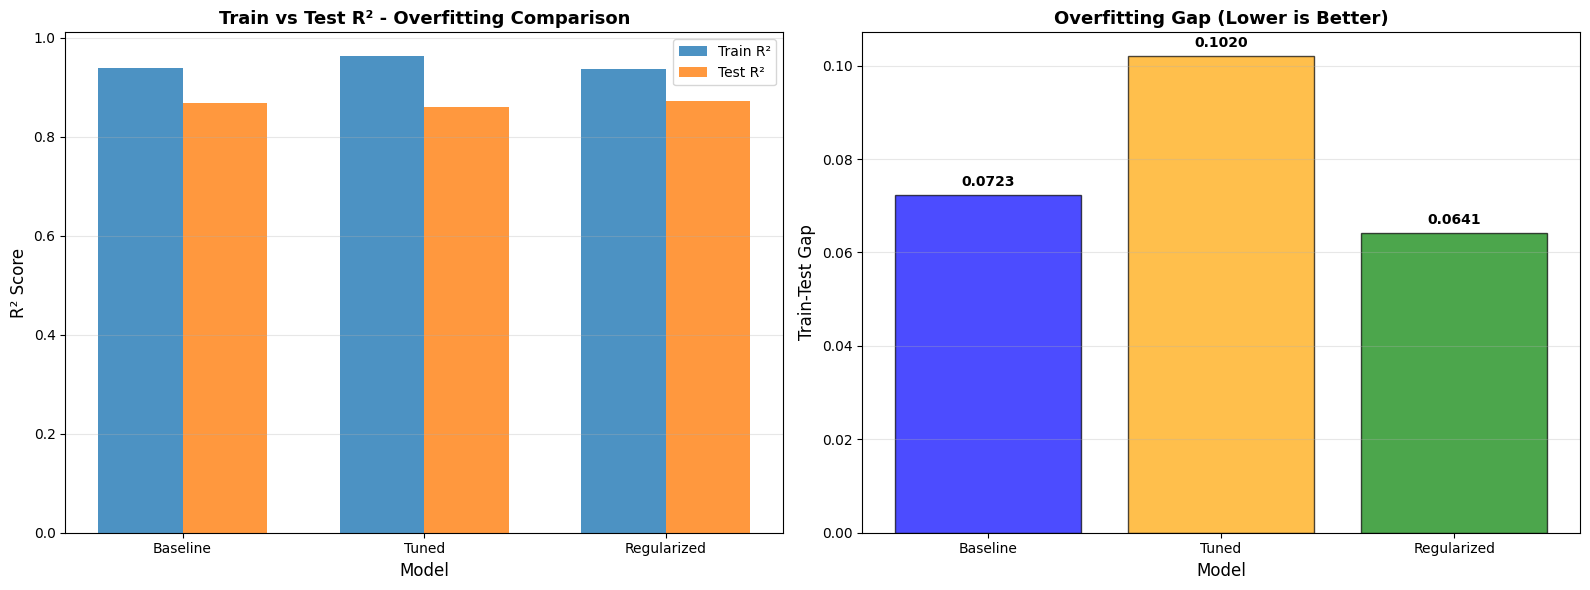

In [16]:
# Compare all three models
comparison_all = pd.DataFrame({
    'Model': ['Baseline', 'Tuned', 'Regularized'],
    'Train R²': [train_r2, train_r2_tuned, train_r2_reg],
    'Test R²': [test_r2, test_r2_tuned, test_r2_reg],
    'Gap': [train_r2 - test_r2, train_r2_tuned - test_r2_tuned, train_r2_reg - test_r2_reg],
    'Test RMSE': [test_rmse, test_rmse_tuned, test_rmse_reg]
})

print("\n" + "="*70)
print("ALL MODELS COMPARISON")
print("="*70)
print(comparison_all.to_string(index=False))
print("="*70)

# Visualize overfitting comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train vs Test R² comparison
x = np.arange(len(comparison_all['Model']))
width = 0.35

axes[0].bar(x - width/2, comparison_all['Train R²'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, comparison_all['Test R²'], width, label='Test R²', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Train vs Test R² - Overfitting Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_all['Model'])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Overfitting gap
axes[1].bar(comparison_all['Model'], comparison_all['Gap'], color=['blue', 'orange', 'green'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Train-Test Gap', fontsize=12)
axes[1].set_title('Overfitting Gap (Lower is Better)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(comparison_all['Gap']):
    axes[1].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 14. Aggressive Anti-Overfitting Model

In [17]:
# Very aggressive regularization to eliminate overfitting
xgb_aggressive = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,              # Much shallower trees (was 5)
    learning_rate=0.03,       # Much slower learning (was 0.05)
    subsample=0.6,            # More aggressive sampling (was 0.7)
    colsample_bytree=0.6,     # More aggressive feature sampling (was 0.7)
    reg_alpha=10,             # Much stronger L1 (was 1)
    reg_lambda=100,           # Much stronger L2 (was 10)
    min_child_weight=10,      # Larger minimum samples per leaf (was 3)
    gamma=0.5,                # Minimum loss reduction to split (NEW!)
    random_state=42,
    n_jobs=-1
)

print("Training aggressive anti-overfitting model...")
xgb_aggressive.fit(X_train, y_train)

# Make predictions
y_pred_train_agg = xgb_aggressive.predict(X_train)
y_pred_test_agg = xgb_aggressive.predict(X_test)

# Evaluate
train_r2_agg = r2_score(y_train, y_pred_train_agg)
test_r2_agg = r2_score(y_test, y_pred_test_agg)
train_rmse_agg = np.sqrt(mean_squared_error(y_train, y_pred_train_agg))
test_rmse_agg = np.sqrt(mean_squared_error(y_test, y_pred_test_agg))
test_mae_agg = mean_absolute_error(y_test, y_pred_test_agg)
gap_agg = train_r2_agg - test_r2_agg

print(f"Training R²: {train_r2_agg:.4f}")
print(f"Testing R²: {test_r2_agg:.4f}")
print(f"Train-Test Gap: {gap_agg:.4f} ⬅️ TARGET: < 0.05")
print(f"\nTraining RMSE: ${train_rmse_agg:,.2f}")
print(f"Testing RMSE: ${test_rmse_agg:,.2f}")
print(f"Testing MAE: ${test_mae_agg:,.2f}")
print("="*50)

print(f"Tuned model gap: {train_r2_tuned - test_r2_tuned:.4f}")
print(f"Aggressive model gap: {gap_agg:.4f}")
print(f"Gap reduction: {(train_r2_tuned - test_r2_tuned) - gap_agg:.4f}")

Training aggressive anti-overfitting model...
Training R²: 0.8654
Testing R²: 0.8610
Train-Test Gap: 0.0044 ⬅️ TARGET: < 0.05

Training RMSE: $132,590.30
Testing RMSE: $144,934.79
Testing MAE: $82,939.60
Tuned model gap: 0.1020
Aggressive model gap: 0.0044
Gap reduction: 0.0976
Training R²: 0.8654
Testing R²: 0.8610
Train-Test Gap: 0.0044 ⬅️ TARGET: < 0.05

Training RMSE: $132,590.30
Testing RMSE: $144,934.79
Testing MAE: $82,939.60
Tuned model gap: 0.1020
Aggressive model gap: 0.0044
Gap reduction: 0.0976



FINAL MODEL COMPARISON - OVERFITTING ANALYSIS
      Model  Train R²  Test R²  Overfitting Gap     Test RMSE
   Baseline  0.939570 0.867268         0.072303 141654.690979
      Tuned  0.962831 0.860792         0.102038 145068.766844
Regularized  0.936807 0.872670         0.064138 138742.189930
 Aggressive  0.865439 0.861049         0.004390 144934.786027

✅ Best model = Lowest 'Overfitting Gap' while maintaining good Test R²


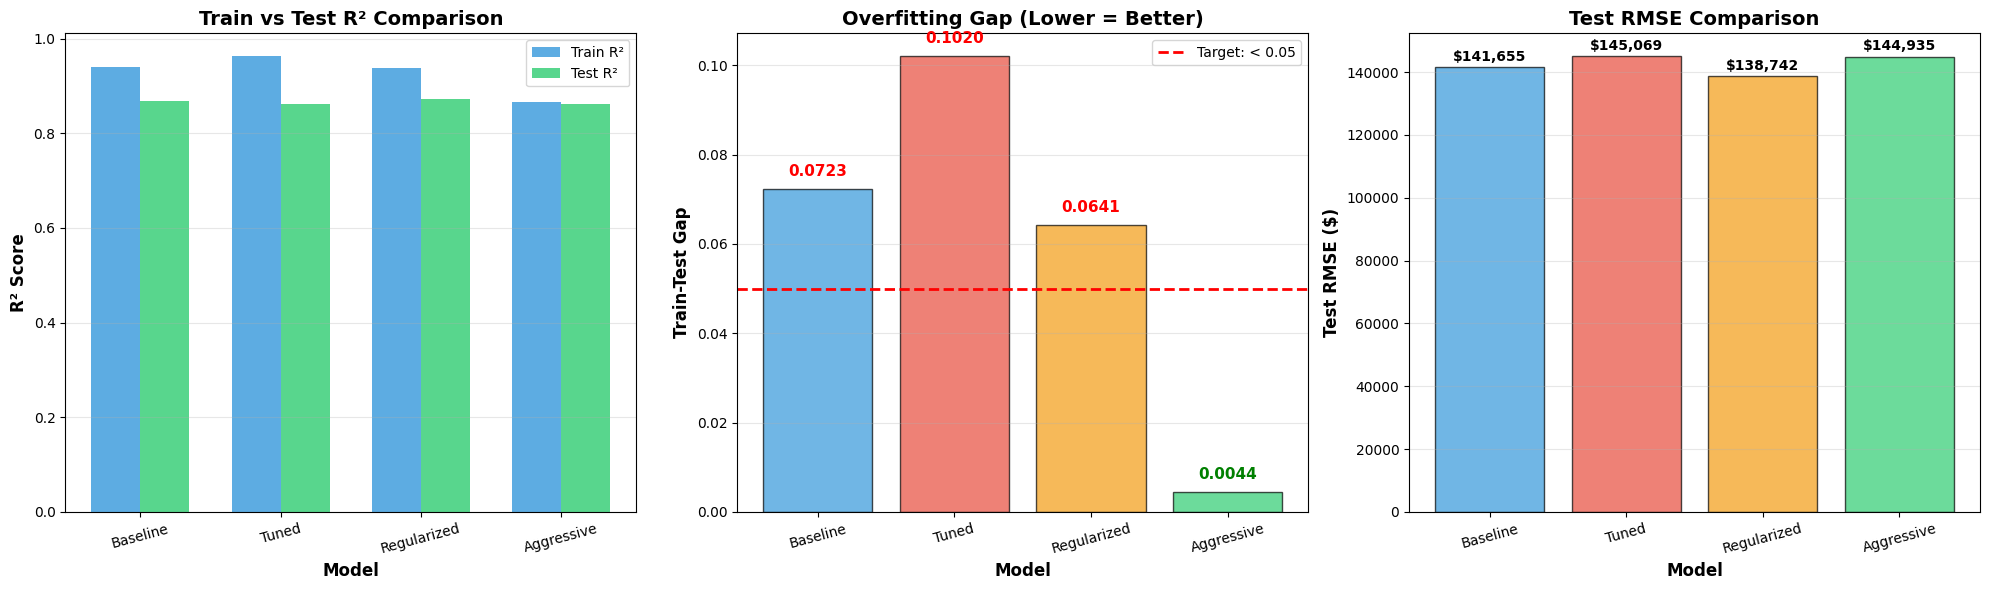

In [18]:
# Final comparison: All 4 models
comparison_final = pd.DataFrame({
    'Model': ['Baseline', 'Tuned', 'Regularized', 'Aggressive'],
    'Train R²': [train_r2, train_r2_tuned, train_r2_reg, train_r2_agg],
    'Test R²': [test_r2, test_r2_tuned, test_r2_reg, test_r2_agg],
    'Overfitting Gap': [
        train_r2 - test_r2, 
        train_r2_tuned - test_r2_tuned, 
        train_r2_reg - test_r2_reg, 
        gap_agg
    ],
    'Test RMSE': [test_rmse, test_rmse_tuned, test_rmse_reg, test_rmse_agg]
})

print("\n" + "="*80)
print("FINAL MODEL COMPARISON - OVERFITTING ANALYSIS")
print("="*80)
print(comparison_final.to_string(index=False))
print("="*80)
print("\n✅ Best model = Lowest 'Overfitting Gap' while maintaining good Test R²")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = comparison_final['Model']
x_pos = np.arange(len(models))

# 1. Train vs Test R² comparison
width = 0.35
axes[0].bar(x_pos - width/2, comparison_final['Train R²'], width, label='Train R²', alpha=0.8, color='#3498db')
axes[0].bar(x_pos + width/2, comparison_final['Test R²'], width, label='Test R²', alpha=0.8, color='#2ecc71')
axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Train vs Test R² Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=15)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Overfitting gap (lower is better)
colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']
bars = axes[1].bar(models, comparison_final['Overfitting Gap'], color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Target: < 0.05')
axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Train-Test Gap', fontsize=12, fontweight='bold')
axes[1].set_title('Overfitting Gap (Lower = Better)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

for i, (bar, v) in enumerate(zip(bars, comparison_final['Overfitting Gap'])):
    color = 'green' if v < 0.05 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 0.003, f'{v:.4f}', 
                ha='center', fontweight='bold', color=color, fontsize=11)

# 3. Test RMSE comparison
axes[2].bar(models, comparison_final['Test RMSE'], color=colors, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Test RMSE ($)', fontsize=12, fontweight='bold')
axes[2].set_title('Test RMSE Comparison', fontsize=14, fontweight='bold')
axes[2].tick_params(axis='x', rotation=15)
axes[2].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(comparison_final['Test RMSE']):
    axes[2].text(i, v + 2000, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 16. Feature Standardization for Performance Improvement

XGBoost is generally scale-invariant (doesn't require scaling), but standardization can help:
- Reduce numerical instability
- Speed up convergence
- Improve performance with regularization
- Help with feature importance interpretation

We'll test StandardScaler (mean=0, std=1) and compare results.


In [ ]:
# Apply StandardScaler to the features
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to keep feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("="*70)
print("FEATURE STANDARDIZATION APPLIED")
print("="*70)
print(f"Original feature ranges (before scaling):")
print(f"  sqft_living: [{X_train['sqft_living'].min():.0f}, {X_train['sqft_living'].max():.0f}]")
print(f"  grade: [{X_train['grade'].min():.0f}, {X_train['grade'].max():.0f}]")
print(f"  lat: [{X_train['lat'].min():.4f}, {X_train['lat'].max():.4f}]")

print(f"\nScaled feature ranges (after standardization):")
print(f"  sqft_living: [{X_train_scaled['sqft_living'].min():.4f}, {X_train_scaled['sqft_living'].max():.4f}]")
print(f"  grade: [{X_train_scaled['grade'].min():.4f}, {X_train_scaled['grade'].max():.4f}]")
print(f"  lat: [{X_train_scaled['lat'].min():.4f}, {X_train_scaled['lat'].max():.4f}]")

print(f"\nScaled features - Mean: ~0, Std: ~1")
print(f"  sqft_living mean: {X_train_scaled['sqft_living'].mean():.6f}, std: {X_train_scaled['sqft_living'].std():.6f}")
print("="*70)


In [ ]:
# Train XGBoost model on SCALED data (using aggressive anti-overfitting parameters)
print("Training XGBoost on SCALED features...")

xgb_scaled = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=10,
    reg_lambda=100,
    min_child_weight=10,
    gamma=0.5,
    random_state=42,
    n_jobs=-1
)

xgb_scaled.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train_scaled = xgb_scaled.predict(X_train_scaled)
y_pred_test_scaled = xgb_scaled.predict(X_test_scaled)

# Evaluate
train_r2_scaled = r2_score(y_train, y_pred_train_scaled)
test_r2_scaled = r2_score(y_test, y_pred_test_scaled)
train_rmse_scaled = np.sqrt(mean_squared_error(y_train, y_pred_train_scaled))
test_rmse_scaled = np.sqrt(mean_squared_error(y_test, y_pred_test_scaled))
test_mae_scaled = mean_absolute_error(y_test, y_pred_test_scaled)
gap_scaled = train_r2_scaled - test_r2_scaled

print("\n" + "="*70)
print("SCALED FEATURES MODEL PERFORMANCE")
print("="*70)
print(f"Training R²: {train_r2_scaled:.4f}")
print(f"Testing R²: {test_r2_scaled:.4f}")
print(f"Train-Test Gap: {gap_scaled:.4f}")
print(f"\nTraining RMSE: ${train_rmse_scaled:,.2f}")
print(f"Testing RMSE: ${test_rmse_scaled:,.2f}")
print(f"Testing MAE: ${test_mae_scaled:,.2f}")
print("="*70)

# Compare with non-scaled aggressive model
print(f"\n📊 COMPARISON WITH NON-SCALED MODEL:")
print(f"Test R² change: {(test_r2_scaled - test_r2_agg):+.4f}")
print(f"Test RMSE change: ${(test_rmse_scaled - test_rmse_agg):+,.2f}")
print(f"Gap change: {(gap_scaled - gap_agg):+.4f}")

if test_rmse_scaled < test_rmse_agg:
    improvement = (test_rmse_agg - test_rmse_scaled) / test_rmse_agg * 100
    print(f"\n✅ IMPROVEMENT: RMSE reduced by ${test_rmse_agg - test_rmse_scaled:,.2f} ({improvement:.2f}%)")
else:
    decline = (test_rmse_scaled - test_rmse_agg) / test_rmse_agg * 100
    print(f"\n❌ DECLINE: RMSE increased by ${test_rmse_scaled - test_rmse_agg:,.2f} ({decline:.2f}%)")


In [ ]:
# Final comparison: All 5 models (including scaled)
comparison_with_scaling = pd.DataFrame({
    'Model': ['Baseline', 'Tuned', 'Regularized', 'Aggressive', 'Scaled'],
    'Train R²': [train_r2, train_r2_tuned, train_r2_reg, train_r2_agg, train_r2_scaled],
    'Test R²': [test_r2, test_r2_tuned, test_r2_reg, test_r2_agg, test_r2_scaled],
    'Gap': [
        train_r2 - test_r2, 
        train_r2_tuned - test_r2_tuned, 
        train_r2_reg - test_r2_reg, 
        gap_agg,
        gap_scaled
    ],
    'Test RMSE': [test_rmse, test_rmse_tuned, test_rmse_reg, test_rmse_agg, test_rmse_scaled],
    'Test MAE': [test_mae, test_mae_tuned, test_mae_reg, test_mae_agg, test_mae_scaled]
})

print("\n" + "="*80)
print("FINAL COMPARISON: ALL MODELS (INCLUDING SCALED)")
print("="*80)
print(comparison_with_scaling.to_string(index=False))
print("="*80)

# Determine best model
best_idx = comparison_with_scaling['Test RMSE'].idxmin()
best_model_name = comparison_with_scaling.loc[best_idx, 'Model']
best_rmse = comparison_with_scaling.loc[best_idx, 'Test RMSE']
best_r2 = comparison_with_scaling.loc[best_idx, 'Test R²']
best_gap = comparison_with_scaling.loc[best_idx, 'Gap']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test RMSE: ${best_rmse:,.2f}")
print(f"   Test R²: {best_r2:.4f}")
print(f"   Overfitting Gap: {best_gap:.4f}")
